# Introduction

"Or yet in wise old Ravenclaw, 
If you have a ready mind, 
Where those of wit and learning, 
Will always find their kind."

But what exactly is one's kind? How does Facebook recommend you friends? True to Ravenclaw tradition, our query led to this project, which delved into applying machine learning algorithms to the task of predicting graph connections.


## Graphs: A Brief Introduction
A graph in the sense of this project is very different to the type of graph that is used to describe the relationship between two variables (i.e. two axes, dependent and independent variable). This project concerns the mathematical definition of a graph which is a structure indicating the connections between a set of objects. 

This **graph** is defined as $(V,E)$ where $V$ is a set of vertices representing the objects in question, and $E$ is a set of pairs $(u,v)$ with $u, v \in V$ of vertices indicating the connections or "edges" between the vertices. Vertices are also often referred to as "nodes" as well. 

In an edge set, if $(u,v)$ is considered the same as $(v,u)$, the graph is called undirected and the graph is considered directed if they are different, the nomenclature indicating the usage of directed graphs in representing problems where there is a sense of "directions" between vertices. 

Imagine you're on Tinder: nodes are people like you, and edges are lines connecting people (the nodes) together. Edges can be directed (two-way) or undirected (one-way). In the Tinder example, directed may mean both have swiped on each other while undirected may point to a single-sided affair.

Graphs also can have other parameters (in this project, we study **temporal graphs** which have a time parameter over which the connections vary).

They are often used to represent situations as they are a good analogy for connections between locations by roads, flight paths, and other modes of transport or the connections establised in human communication. They have extensive applications in data science as questions that concern connections of any kind or flows through structures can easily be represented with graphs.

This project is made specific to graphs based on the usage of concepts reletated inherently to the representation of the data by a graph in the machine learning methodology. We define these briefly here. A **path** is a collection of distinct edges $(e_1,e_2,...,e_{n-1})$ such that there is a sequence of nodes $(v_1,...,v_n)$ such that $e_i = (v_i, v_{i+1})$ and we call the length of the path the number of edges in it. Furthermore, **connected component** is a subset of the vertices such that, for any two vertices in the set, there is a path with those vertices as $v_1$, and $v_n$. In addition, the **degree** of a node is the number of edges it is an element of, and its degree centrality is the same as the degree. The **distance** between two nodes $d(u,v)$ is the length of the shortest path between them with the distance being conventionally infinite if there is no such path. 

## Datasets
This project utilises two graph datasets that arise from real world situations. They were sourced from  [the Stanford Large Network Dataset Collection]( https://snap.stanford.edu/data/). The first is the Google Plus dataset that represents connections between users of the Google Plus social network. The second is a dataset representing emails sent between employees of a large European Research Institution. This is a temporal dataset (times at which emails were sent were recorded). While it is split between 4 departments, we have decided to analyze them in totality.

To those who don't know, Google+ was a social networking site that was created in 2011 before it was closed in April 2019. It had a feature called *share circle* which allowed users to share their network data, including node features, circles, and ego networks. The ego networks are formed by each node's connections and the features indclude data about each person that is sufficent for for some analyses but for the dataset to also remain anonymised. 

In our analysis we make use of the [NetworkX](https://networkx.org/documentation/stable) Python package to transoform the edge list data frame into a Python Graph object.

In [2]:
import networkx as nx
import pandas as pd
import numpy as np
import stellargraph as sg
import matplotlib.pyplot as plt

%matplotlib inline

2022-03-20 10:28:23.004719: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
path = 'data/email-Eu-core-temporal.txt'

In [4]:
# Email Dataset
# Reading Edges Text File into List
edges = []
with open(path) as f:
     for line in f:
        line = line.strip()
        if line != '':
            edges.append(line)
            
# Reading Edges Text File into Dataframe
e_df = pd.read_csv(path, delim_whitespace=True, 
                   names=['Source', 'Destination', 'Time'])

# Reading Edges List into Graph
new_df = e_df.drop(columns=['Time'])
e_graph = nx.from_pandas_edgelist(new_df, 'Source', 'Destination')
e_df.head()

,Source,Destination,Time
0,582,364,0
1,168,472,2797
2,168,912,3304
3,2,790,4523
4,2,322,7926


In [17]:
# Google Plus Dataset
# Reading Edges Text File into List
edges_g = []
with open('data/gplus_combined.txt') as f:
     for line in f:
        line = line.strip()
        if line != '':
            edges.append(line)
            
# Reading Edges Text File into Dataframe
g_df = pd.read_csv('data/gplus_combined.txt', delim_whitespace=True, 
                   names=['Source', 'Destination', 'Time'])

# Reading Edges List into Graph
g_graph = nx.from_pandas_edgelist(g_df, 'Source', 'Destination')

# Basic Analysis of Datasets

The Google Plus Dataset (G+) is significantly bigger than that of the university email network with 109 times the number of nodes. The average node degree of both datasets (33, 227) differ much more than their median degree (22, 42)—meaning that G+ has a select few with just too many edge connections. 

For our further analysis we will focus only on the  email data set. G+ dataset turned out to be too computationally expensive and a rather sparse network. Choosing a random subset of a graph-type data set brings its own complications.

In [28]:
# Summay of the data
e_degree = pd.DataFrame(
    e_graph.degree(), columns = ['node', 'Email node degree']
).set_index('node').describe()

g_degree = pd.DataFrame(
    g_graph.degree(), columns = ['node', 'G+ node degree']
).set_index('node').describe()

summary_df = pd.concat([e_degree, g_degree], axis=1).astype('int')
summary_df

,Email node degree,G+ node degree
count,986,107614
mean,32,227
std,37,581
min,1,1
25%,6,11
50%,22,42
75%,44,170
max,345,20127


# Temporal Email Dataset 
The total duration of the temporal dataset is 17 months. Divided into 6 periods of approximately 3 months each, we find that each period consists roughly the same amount of nodes and edges (around 800 nodes and 6300 edges)—email frequency was stable throughout.

In [5]:
# Set the breaks between the time periods
breaks = np.linspace(0, 45405138, 7).astype('int')

# Create a dictionary of subgraphs for each time period
subgraph = dict()
for i in range(6):
    subgraph[i] = nx.from_pandas_edgelist(
        e_df[(e_df.Time >= breaks[i]) & (e_df.Time < breaks[i + 1])], 
        'Source', 'Destination'
    )
    
# Print the summary
for i in range(6):
    print("Time period %i:" % (i+1), nx.info(subgraph[i]))

Time period 1: Graph with 781 nodes and 5873 edges
Time period 2: Graph with 771 nodes and 5908 edges
Time period 3: Graph with 788 nodes and 6656 edges
Time period 4: Graph with 754 nodes and 5660 edges
Time period 5: Graph with 820 nodes and 6221 edges
Time period 6: Graph with 848 nodes and 7620 edges


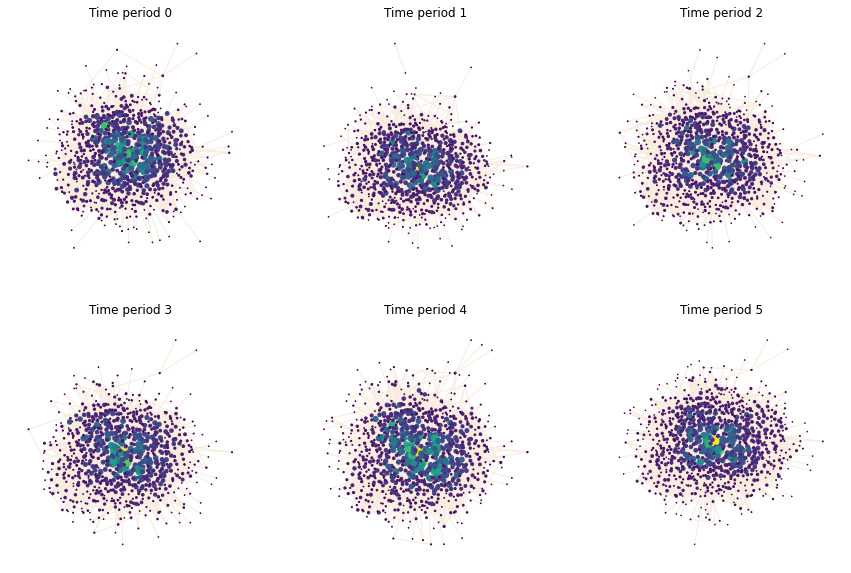

In [6]:
def plot_graph(g, node_size, ax, pos=None):
    node_color = [200 * g.degree(i) for i in g]
    node_size = node_size / (node_size.max() - node_size.min()) * 80
    if pos is None:
        pos = nx.kamada_kawai_layout(g)
    nx.draw_networkx(
        g, 
        with_labels=False,
        pos = pos,
        node_size = node_size,
        node_color= node_color,
        edge_color='#F7ECDE',
        width = 1.0,
        ax=ax
    )
    ax.axis('off')
    
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
pos = nx.kamada_kawai_layout(e_graph)
for i in range(6):
    centrality = np.fromiter(nx.degree_centrality(subgraph[i]).values(), dtype=float)
    plot_graph(subgraph[i], centrality, ax[i // 3, i % 3], pos=pos)
    ax[i // 3, i % 3].set_title('Time period %i' % (i + 1))

## Centrality Analyses
Centrality seeks to answer the question of which node is the most important. To achieve this, we can use a multitude of mathematical definitions of how "central" a node is. In this project, we focus on four measures of centrality:

1. **Degree**

The most important node would be the one with the most edges. Simple and intuitive.
Degree centrality of a node $x$ is defined as $$\sum_{y \in V} \frac{1}{d(x,y)}$$

2. **Closeness**

By measuring the average distance of a node to all other nodes, the cardinal node is determined to be the one closest to everybody.
The closeness of a node $x$ is defined as $$\frac{\sum_{y \in V} d(x,y)}{|V|}$$

3. **Betweenness**

The betweenness centrality is a measure of how often a node appears "between" two others. Nodes with a high betweenness centrality are important as they can control the flow of information through a graph to the greatest extent. In order to formally define this, if $s$, $t$, $v$ are nodes, we define $\sigma_{st}(v)$ to be the number of shortest paths from $s$ to $t$ that pass through $v$. Furthermore, we let $\sigma_{st}$ to be the total number of those shortest paths. We how state that the betweenness centrality of the node $v$ is defined as
$$g(v) = \sum_{s \neq t \neq v}\frac{\sigma_{st}(v)}{\sigma_{st}}$$

4. **Eigenvector**

We do not go into the explanation for why this method is followed however, we state it here. The largest eigenvalue of the adjacency matrix is computed and the eigenvector centrality of a node is the corresponding position in that eigenvalue's eigenvector. This means that if our vertices are $(v_1,...,v_n)$, the vector of eigenvalue centralities $x$ satisfies $$Ax = \lambda x$$ where $A$ is the adjacency matrix and $\lambda$ is the largest eigenvalue.

For all the centrality measures we plot the entire graph such the size of its nodes corresponds to their centrality.

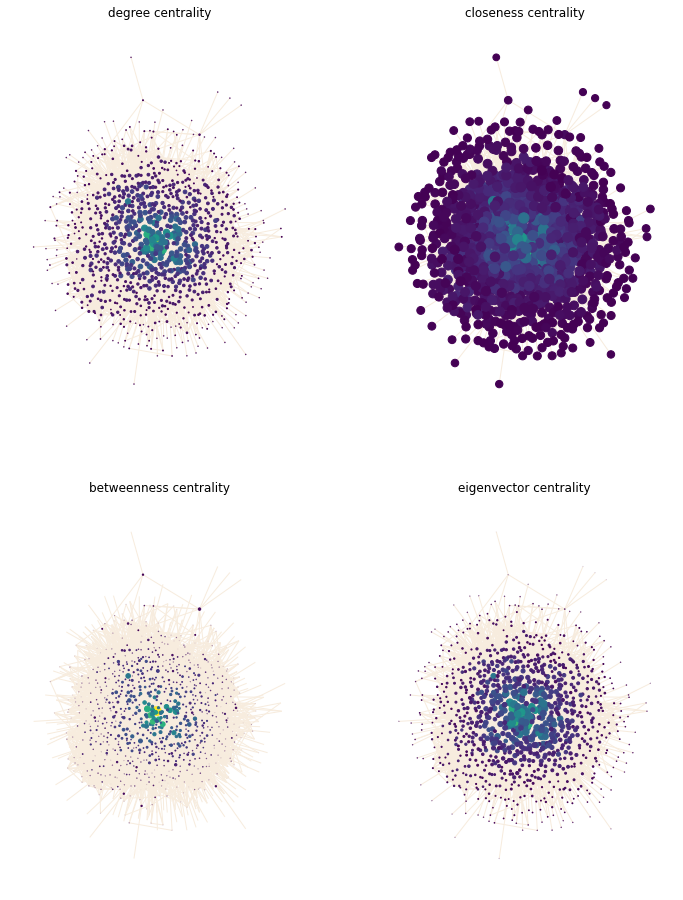

In [25]:
# Compute the centralities
centralities = dict()
centralities['degree'] = np.fromiter(nx.degree_centrality(e_graph).values(), dtype=float)
centralities['closeness'] = np.fromiter(nx.closeness_centrality(e_graph).values(), dtype=float)
centralities['betweenness'] = np.fromiter(nx.betweenness_centrality(e_graph).values(), dtype=float)
centralities['eigenvector'] = np.fromiter(nx.eigenvector_centrality(e_graph).values(), dtype=float)

fig, ax = plt.subplots(2, 2, figsize=(12, 16))
for i, measure in enumerate(centralities.keys()):
    plot_graph(e_graph, centralities[measure], ax=ax[i // 2, i % 2])
    ax[i // 2, i % 2].set_title(measure + " centrality")

## Link Prediction
Now we shall endeavour to predict the links.
We will be doing it in a simple manner: remove a sample of links, and calculate the model accuracy in predicting the missing links.

This project utilises [Node2Vec](https://snap.stanford.edu/node2vec/), an algorithm that utilises second order random walks. A **random walk** is when, starting at a particular node, we pick an edge that is incident at that node and then "walk" along it to the next node. Effectively, we choose a random path in the graph with one of the end nodes being the starting node in the graph. In a second order random walk, the algorithm trains a neural network to predict what will happen next depending on the occurrence of other nodes. This network then influences the probability that a node will be selected in a random walk based on this.

Given a graph, Node2Vec creates a lower-dimensional representation of it referred to as an **embedding**. For our prediction task, instead of training the models on the entire adjacency matrix of the graph, we create an embedding of our the network that captures the most of its structure while reducing the number of dimensions. These embeddings later serve us as the input to the standard machine learning algorithms. We test the Node2Vec embeddings on four classifiers:

**Logistic Regression**, this is the simplest binary linear classifier. Logistic regression is an extension of the linear regression model for classification problems.

**Support Vector Classifier**, the objective of the support vector machine algorithm is to find a hyperplane in an $p$-dimensional space ($p$ — the number of features) that distinctly classifies the data points. To separate the two classes of data points, there are many possible hyperplanes that could be chosen. The goal is to find a plane that has the maximum margin, i.e the maximum distance between data points of both classes. 


**Gradient Boosting** is when we use multiple functions to learn the main quantity in question. Each of these are referred to as "weak learners" and their combination constitutes the overall behaviour of the predctions of the model. This approach typically outperforms simple random forest classification and, in the case of sklearn, the weak learners are in fact decision trees.

**MLP Classifier** is a multilayer perceptron classfier and uses stochastic gradient descent to optimise the log-loss function. This differs from a logistic regression as there can be hidden layers that give more parameters, thereby allowing the model to use more complex shapes when fitting the model. In addition stochastic gradient descent is a more sophisticated version of gradient descent that is faster for large data sets and is helpful where there are large redundancies in the data.

### Construct splits of the input data

We need to be carful how to split our data intro training, validation and test sets in order to avoid **data leakage**.

We make use of the `EdgeSplitter` from the [StellarGraph](https://stellargraph.readthedocs.io/en/stable/) Python package and the standard `train_test_split` function from [scikit-learn](https://scikit-learn.org/stable/) for creating the following subsets of the original data:

- A **Train Graph** for computing node embeddings (`graph_train`)
- A training set of positive and negative edges that weren’t used for computing node embeddings for training classifiers (`edges_train`)
- A validation set for choosing the best classifier, i.e. a set of positive and negative edges that weren’t used for computing node embeddings or training the classifier (`edges_val`)
- A **Test Graph** to compute test node embeddings (`graph_test`), and a test set (`edges_test`) of positive and negative edges not used for neither computing the test node embeddings or for classifier training or model selection 

In [8]:
from stellargraph.data import EdgeSplitter
from sklearn.model_selection import train_test_split

sg_graph = sg.StellarGraph.from_networkx(e_graph)

# Define an edge splitter on the full graph:
edge_splitter_test = EdgeSplitter(sg_graph)

# Randomly sample a fraction p=0.1 of all positive links
# and same number of negative links
graph_test, edges_test, labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", seed=0
)

# Get the training subset from within the test graph
edge_splitter_train = EdgeSplitter(graph_test, sg_graph)
graph_train, edges, labels = edge_splitter_train.train_test_split(
    p=0.1, method="global", seed=0
)
(edges_train, edges_val, labels_train, labels_val) \
= train_test_split(edges, labels, train_size=0.75, test_size=0.25, random_state=0)

** Sampled 1606 positive and 1606 negative edges. **
** Sampled 1445 positive and 1445 negative edges. **


In [9]:
pd.DataFrame(
    [
        (
            "Training",
            len(edges_train),
            "Train Graph",
            "Test Graph",
            "Train the Link Classifier",
        ),
        (
            "Validation",
            len(edges_val),
            "Train Graph",
            "Test Graph",
            "Select the best Link Classifier model",
        ),
        (
            "Test",
            len(edges_test),
            "Test Graph",
            "Full Graph",
            "Evaluate the best Link Classifier",
        ),
    ],
    columns=("Split", "Number of Examples", "Hidden from", "Picked from", "Use"),
).set_index("Split")

,Number of Examples,Hidden from,Picked from,Use
Split,,,,
Training,2167,Train Graph,Test Graph,Train the Link Classifier
Validation,723,Train Graph,Test Graph,Select the best Link Classifier model
Test,3212,Test Graph,Full Graph,Evaluate the best Link Classifier


### Train and validate the link prediction model

There are a few steps involved in using the Node2Vec model to perform link prediction: 

1. Generate features for the positive and negative edge samples by calculating a *distance* between the  embeddings of the source and target nodes of each sampled edge. (Here we will use the L1 distance) 
2. Given the features, we train four binary classifiers to predict whether an edge between two nodes should exist or not. 
3. Evaluate the performance of the link classifier for each of the four classifier on the validation set  with node embeddings calculated on the Train Graph, and select the best classifier. 
4. The best classifier is finally used to calculate scores on the test data with node embeddings calculated on the Test Graph.

The number of positive and negative examples in each set used for training, validating and testing is set to be the same. Therefore, we can use accuracy as the defualt model selection metric. 

In [11]:
from stellargraph.data import BiasedRandomWalk
from gensim.models import Word2Vec

dimensions = 64
num_walks = 10
walk_length = 80
window_size = 10
workers = 4
seed = 0

def embed_graph(graph):
    rw = BiasedRandomWalk(graph, seed=seed)
    walks = rw.run(graph.nodes(), n=num_walks, length=walk_length)
    model = Word2Vec(
        walks,
        vector_size=dimensions,
        window=window_size,
        min_count=0,
        sg=1,
        workers=workers,
        seed=seed
    )

    def get_embedding(u):
        return model.wv[u]

    return get_embedding

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler


def get_features(edges, get_embedding):
    return [
        np.abs(get_embedding(src) - get_embedding(dst)) 
        for src, dst in edges
    ]

def train(mod_name, edges, labels, get_embedding):
    clf = classifier(mod_name)
    features = get_features(edges, get_embedding)
    clf.fit(features, labels)
    return clf

def classifier(mod_name, max_iter=2000, seed=0):
    if mod_name == "Logistic Regression":
        clf = LogisticRegression(max_iter=max_iter, random_state=seed)
    elif mod_name == "SVC":
        clf = SVC(max_iter=max_iter, random_state=seed)
    elif mod_name == "Gradient Boosting":
        clf = GradientBoostingClassifier(random_state=seed)
    elif mod_name == "MLP":
        clf = MLPClassifier(max_iter=max_iter, random_state=seed)
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", clf)])

def evaluate(clf, test_edges, test_labels, get_embedding):
    test_features = get_features(test_edges, get_embedding)
    predicted = clf.predict(test_features)
    score = accuracy_score(test_labels, predicted) * 100
    return score

In [13]:
train_embedding = embed_graph(graph_train)
model_names = ['Logistic Regression', 'SVC', 'Gradient Boosting', 'MLP']
models = dict.fromkeys(model_names)
scores = dict.fromkeys(model_names)

for mod_name in model_names:
    models[mod_name] = train(
        mod_name, edges_train, labels_train, train_embedding
    )
    scores[mod_name] = evaluate(
        models[mod_name], edges_val, labels_val, train_embedding
    )

In [14]:
round(pd.DataFrame(scores.values(), index=scores.keys(), columns=['Accuracy']), 2)

,Accuracy
Logistic Regression,81.88
SVC,82.30
Gradient Boosting,80.08
MLP,78.01


SVC performs the best, we will use it for our final classifier.

### Evaluate the best model using the test set

Now that we’ve trained and selected our best model, we use a test set of embeddings and calculate a final evaluation score. The Node2Vec combined with SVC achieves 79.67% accuracy on the test set.

In [15]:
test_embedding = embed_graph(graph_test)
test_score = evaluate(models['SVC'], edges_test, labels_test, test_embedding)

print("Test Accuracy of the SVC classifier: {:.2f}%".format(test_score))

Test Accuracy of the SVC classifier: 79.67%


# Further Research

It is worth noting that since this email dataset is temporal, it is certainly possible to use the past (a subset of data from an earlier time period) to predict the future, rather than taking just taking out a random sample of edges. In such case, the link prediction task can be treated as like a time series problem. We would be interested in trying out the approach presented by [Bonner et al. (2019)](https://dro.dur.ac.uk/29741/1/29741.pdf?DDC116+DDD4+wfhf31).

In addition, the email dataset does not contain features of the nodes themselves, while the G+ one does (features such as occupation, university attended, etc.). For the G+ dataset, one can make advantage of knowing the characteristics of each person, thus the similarities between people, not only the graph structure itself. This would potentially allow for better prediction accuracy and for identifying factors that may be significant in forming of friendships, further informing the results.

# Conclusion

In conclusion, this article sought to explain how we can make predictions using graph-type data set. We applied ML models for link prediction, achieving a decent accuracy score of near 80%. While attributes of friends have not been scrutinised, literature of university students points to the same discipline of study ([Ding et al. 2015](https://doi.org/10.1016/j.comcom.2015.07.007)) and similar physical characteristics such as age and gender ([Wang et al. 2018](https://doi.org/10.1016/j.ins.2018.06.029)) - factors which would have affected the common friends number in the first place. But predictions only point to doors, one has many others to knock on, and the onus on them to open.